Data berhasil dimuat dari Excel
Dataset shape: (6, 3)
Periode data: 2010 - 2015

Missing values:
 Tahun               0
Cumulative_Count    0
Energi_Surya_GWh    0
dtype: int64

Outlier Detection:
Outlier Cumulative_Count:
 Series([], Name: Cumulative_Count, dtype: float64)
Outlier Energi_Surya_GWh:
 Series([], Name: Energi_Surya_GWh, dtype: float64)


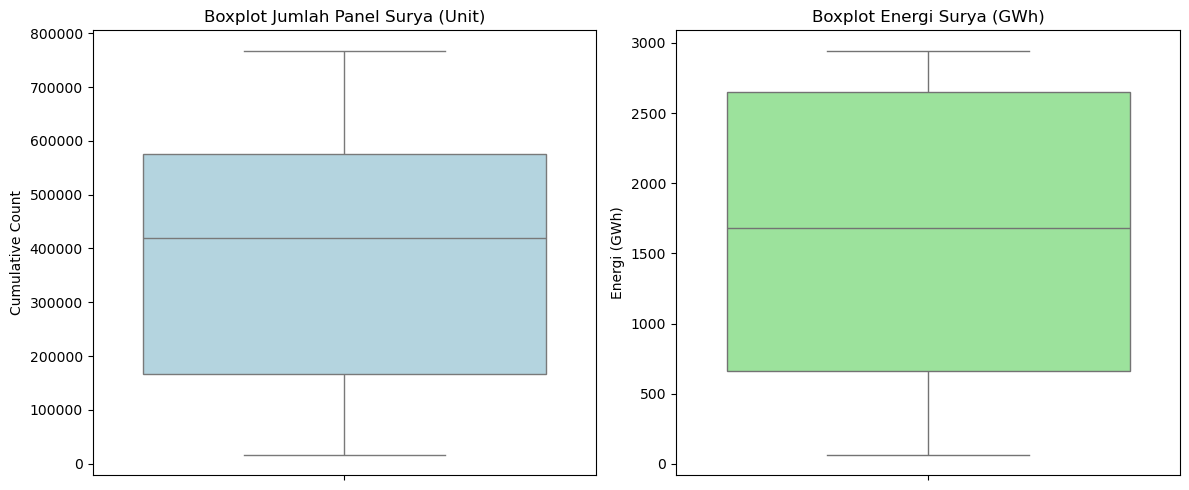


📊 GENERATING VISUALIZATIONS


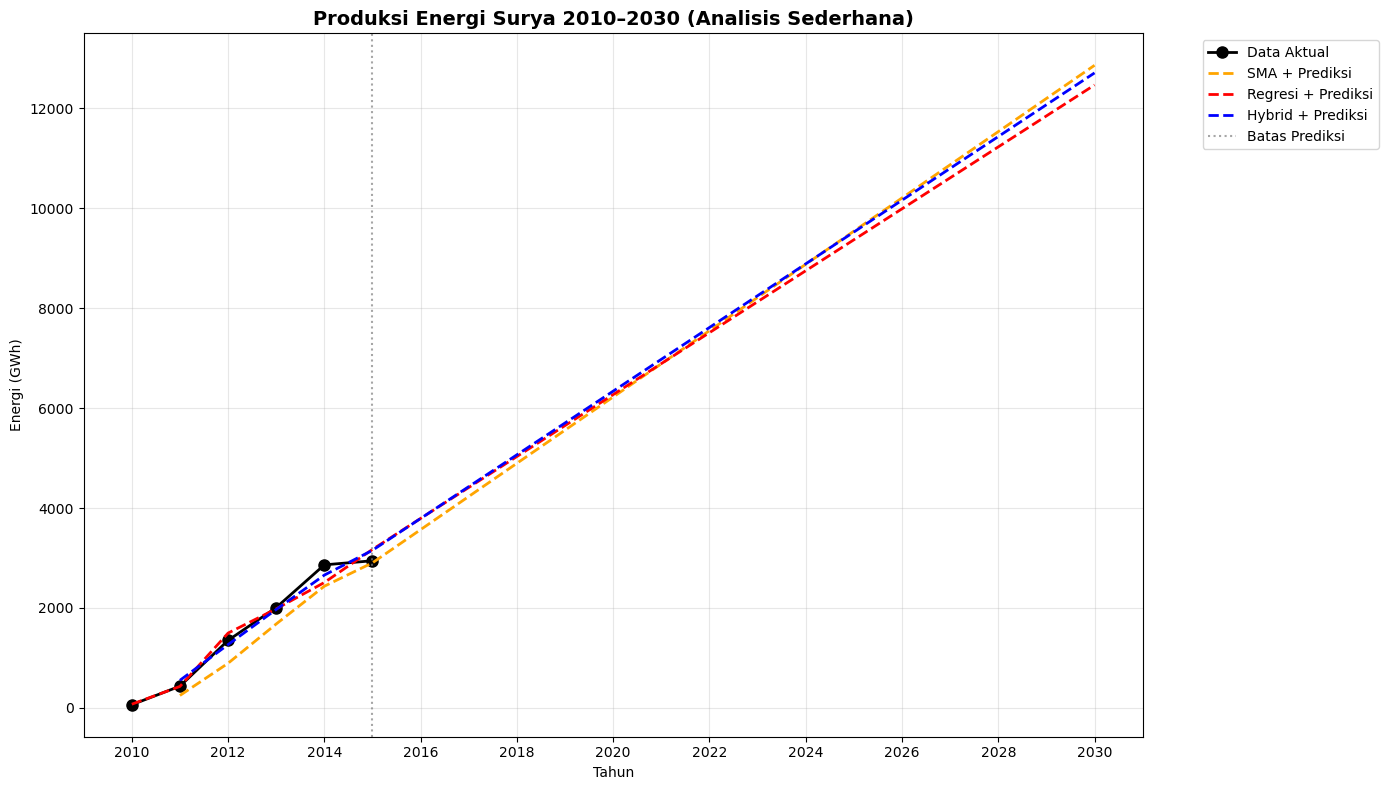

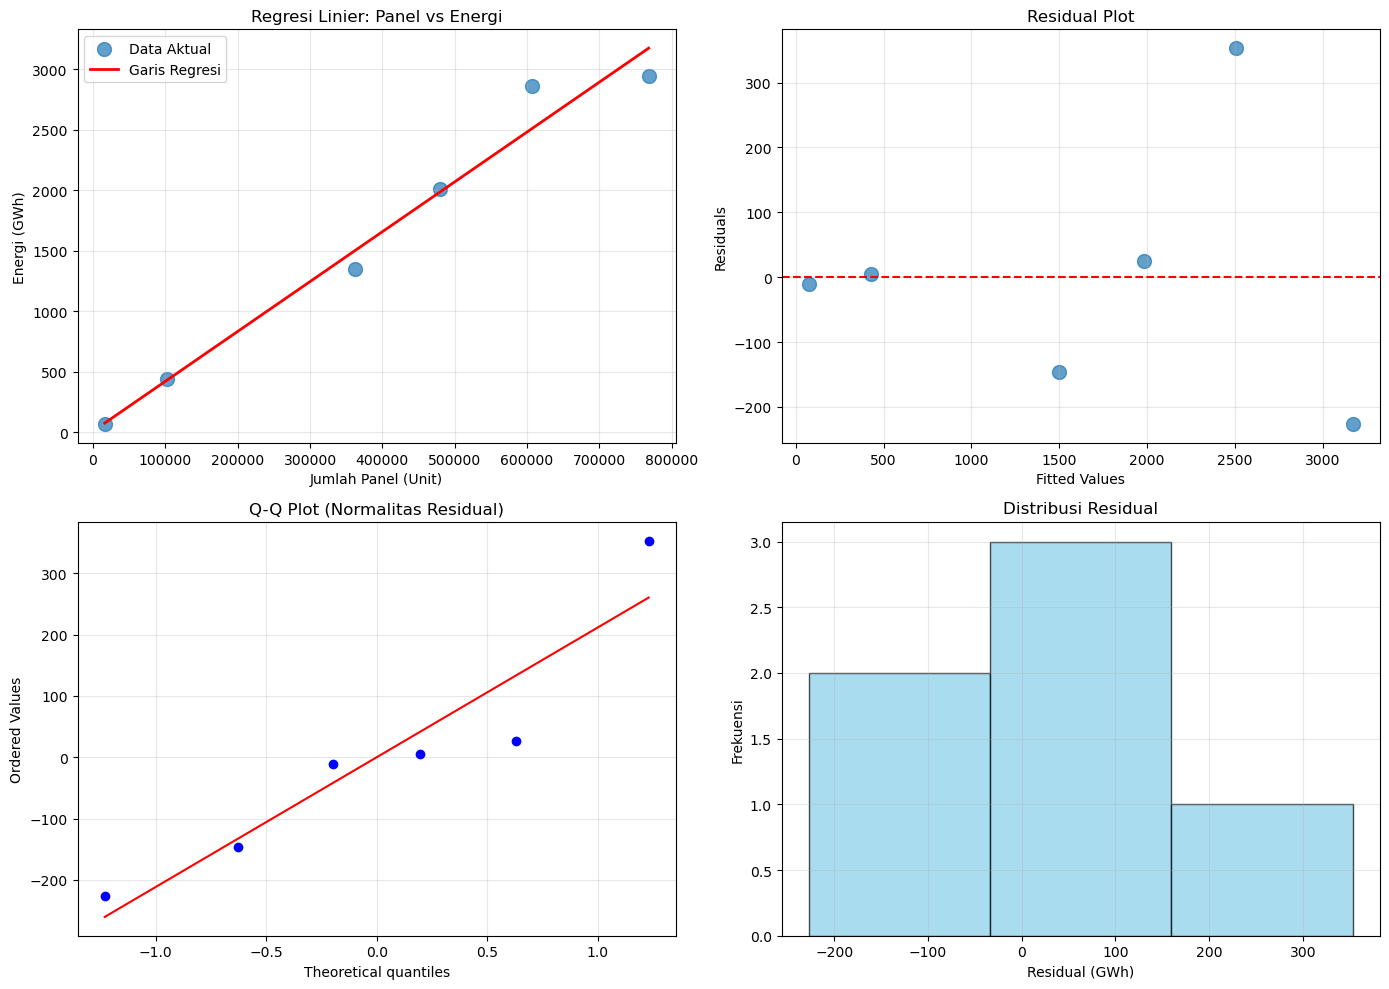

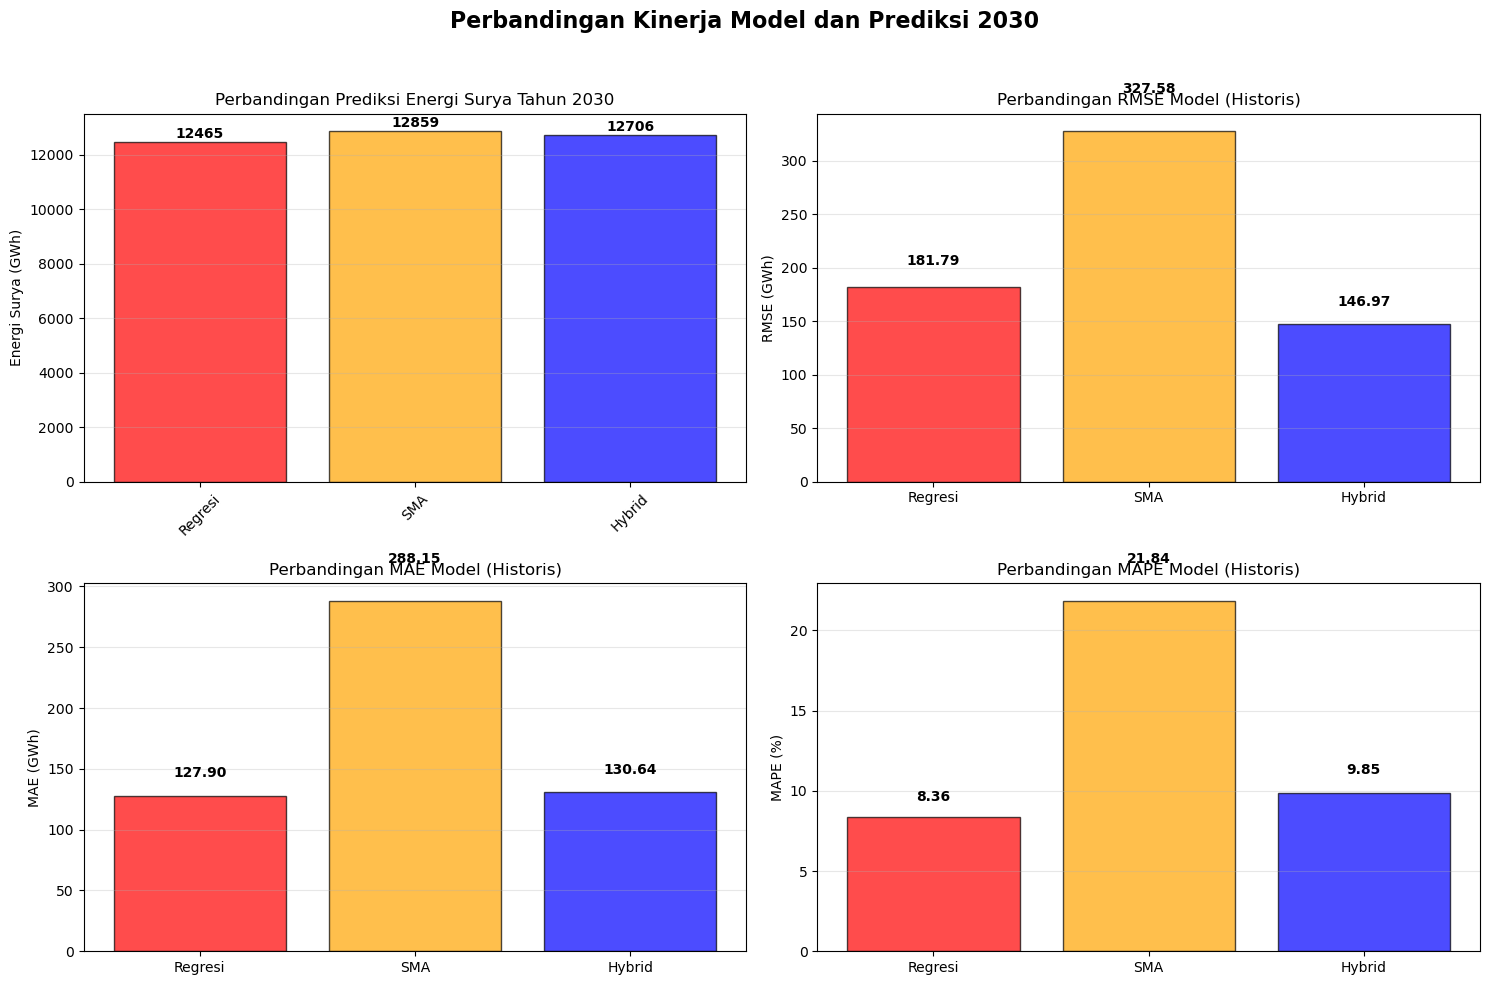


HASIL ANALISIS (SEDERHANA)

DATASET SUMMARY:
  • Jumlah observasi: 6
  • Periode: 2010 - 2015
  • Rata-rata pertumbuhan panel: 150,391 unit/tahun

REGRESI LINIER:
  • Persamaan: Y = 8.42 + 0.004119X
  • R²: 0.9730
  • Metrik Historis - RMSE: 181.79, MAE: 127.90, MAPE: 8.36%
  • Korelasi Pearson (Panel vs Energi) - Koefisien: 0.9864, P-value: 0.0003
    ↳ Kesimpulan: Korelasi signifikan (p < 0.05). Kekuatan: Sangat Kuat.
  • Uji-t Koefisien Panel (β₁) - Statistik t: 12.0102, P-value: 0.0003
Kesimpulan: Koefisien Cumulative_Count signifikan mempengaruhi Energi_Surya_GWh (p < 0.05).
  • Uji Normalitas Residu (Shapiro-Wilk) - P-value: 0.3761
Kesimpulan: Residu terdistribusi normal (p > 0.05).

TIME SERIES MODELS (HISTORIS):
  • SMA - RMSE: 327.58, MAE: 288.15, MAPE: 21.84%

HYBRID MODEL:
  • Persamaan: Y = 273.49 + 0.000862X₁ + 0.76X₂
  • R²: 0.9759
  • Metrik Historis - RMSE: 146.97, MAE: 130.64, MAPE: 9.85%

PREDIKSI 2030:
  • Regresi Linier: 12465 GWh
  • Simple Moving Average: 12859 G

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, t, probplot, shapiro
import warnings
import seaborn as sns
import matplotlib.ticker as ticker

warnings.filterwarnings("ignore")

# 1. Load data
try:
    df = pd.read_excel('cleaned_generation3.xlsx', sheet_name='Sheet1')
    print("Data berhasil dimuat dari Excel")
except FileNotFoundError:
    print("File tidak ditemukan. Menggunakan data dummy.")
    df = pd.DataFrame({
        'Tahun': [2010, 2011, 2012, 2013, 2014, 2015],
        'Cumulative Count (Unit)': [16126, 102491, 361575, 479288, 607267, 768085],
        'Jumlah energi surya (Gwh)': [64, 435.5, 1352, 1785, 2863.1, 2945.5]
    })

# 2. Rename kolom
df.rename(columns={
    'Cumulative Count (Unit)': 'Cumulative_Count',
    'Jumlah energi surya (Gwh)': 'Energi_Surya_GWh'
}, inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Periode data: {df['Tahun'].min()} - {df['Tahun'].max()}")

# 3. Cek missing
print("\nMissing values:\n", df.isnull().sum())

# 4. Deteksi outlier (IQR)
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[(series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)]

print("\nOutlier Detection:")
print("Outlier Cumulative_Count:\n", detect_outliers(df['Cumulative_Count']))
print("Outlier Energi_Surya_GWh:\n", detect_outliers(df['Energi_Surya_GWh']))

# 4a. Deteksi outlier visual dengan boxplot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Cumulative_Count'], color='lightblue')
plt.title('Boxplot Jumlah Panel Surya (Unit)')
plt.ylabel('Cumulative Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Energi_Surya_GWh'], color='lightgreen')
plt.title('Boxplot Energi Surya (GWh)')
plt.ylabel('Energi (GWh)')
plt.tight_layout()
plt.show()

# 4b. Hitung pertumbuhan aktual rata-rata jumlah panel
delta_panel = df['Cumulative_Count'].diff().dropna()
avg_growth_panel = int(delta_panel.mean()) if not delta_panel.empty else 0

# 5. Time Series
# --- Simple Moving Average (SMA) ---
df['SMA_2'] = df['Energi_Surya_GWh'].rolling(window=2).mean()
sma_hist_eval = df['SMA_2'].dropna().values
energi_actual_for_sma_eval = df['Energi_Surya_GWh'].values[len(df) - len(sma_hist_eval):] if len(sma_hist_eval) > 0 else np.array([])

rmse_sma_hist, mae_sma_hist, mape_sma_hist = np.nan, np.nan, np.nan
if len(sma_hist_eval) > 0 and len(energi_actual_for_sma_eval) == len(sma_hist_eval) and len(energi_actual_for_sma_eval)>0:
    rmse_sma_hist = np.sqrt(mean_squared_error(energi_actual_for_sma_eval, sma_hist_eval))
    mae_sma_hist = mean_absolute_error(energi_actual_for_sma_eval, sma_hist_eval)
    mape_sma_hist = np.mean(np.abs((energi_actual_for_sma_eval - sma_hist_eval) / energi_actual_for_sma_eval[energi_actual_for_sma_eval!=0])) * 100 if np.any(energi_actual_for_sma_eval!=0) else np.nan
    # Output metrik SMA dipindahkan ke bagian akhir
else:
    print("Tidak cukup data historis untuk evaluasi SMA.")

# Prediksi SMA 2016–2030
future_years = np.arange(2016, 2031)
sma_growth_hist = np.nan
if len(df['SMA_2'].dropna()) >= 2:
    sma_last_hist = df['SMA_2'].dropna().iloc[-1]
    sma_growth_hist = (sma_last_hist - df['SMA_2'].dropna().iloc[0]) / (len(df['SMA_2'].dropna()) - 1)
    pred_sma = [sma_last_hist + sma_growth_hist * i for i in range(1, len(future_years) + 1)]
elif len(df['SMA_2'].dropna()) == 1:
    pred_sma = [df['SMA_2'].dropna().iloc[0]] * len(future_years)
else:
    pred_sma = [np.nan] * len(future_years)

df_future = pd.DataFrame({
    'Tahun': future_years,
    'SMA_2': pred_sma
})

# 6. Regresi Linier
X = df['Cumulative_Count'].values.reshape(-1, 1)
y = df['Energi_Surya_GWh'].values

beta_0, beta_1, r_squared, rmse_reg, mae_reg, mape_reg = (np.nan,)*6
stat_shapiro_reg, p_normal_reg = (np.nan, np.nan)
corr_reg, p_corr_reg = (np.nan, np.nan)
t_stat_reg, p_t_reg = (np.nan, np.nan)
pred_reg = [np.nan] * len(future_years)
residuals = np.array([])
y_pred = np.array([])
model = None

if len(df) >= 2 and X.shape[0] > 0:
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    beta_0, beta_1 = model.intercept_, model.coef_[0]
    r_squared = model.score(X, y)
    rmse_reg = np.sqrt(mean_squared_error(y, y_pred))
    mae_reg = mean_absolute_error(y, y_pred)
    mape_reg = np.mean(np.abs((y - y_pred) / y[y!=0])) * 100 if np.any(y!=0) else np.nan
    residuals = y - y_pred
    # Output metrik Regresi dipindahkan ke bagian akhir
    
    # Pengujian hipotesis
    if len(residuals) >= 3:
        stat_shapiro_reg, p_normal_reg = shapiro(residuals)
    else:
        print("Tidak cukup data residual untuk uji Shapiro-Wilk.")

    if len(df['Cumulative_Count']) > 1 and len(y) > 1:
        corr_reg, p_corr_reg = pearsonr(df['Cumulative_Count'], y)
    n_reg = len(y)
    if n_reg > 2 and np.sum((X.flatten() - np.mean(X))**2) != 0 :
        se_beta_1 = np.sqrt(np.sum((residuals)**2) / (n_reg - 2)) / np.sqrt(np.sum((X.flatten() - np.mean(X))**2))
        if se_beta_1 != 0:
            t_stat_reg = beta_1 / se_beta_1
            p_t_reg = 2 * (1 - t.cdf(np.abs(t_stat_reg), df=n_reg - 2))
        else:
            print("Standard Error untuk beta_1 adalah nol, uji-t tidak dapat dilakukan.")
    else:
        print("Tidak cukup data atau variasi X untuk uji-t pada beta_1.")

    last_count = df['Cumulative_Count'].iloc[-1] if not df.empty else 0
    future_counts = [last_count + avg_growth_panel * i for i in range(1, len(future_years) + 1)]
    pred_reg = model.predict(np.array(future_counts).reshape(-1, 1))
else:
    print("Tidak cukup data untuk analisis regresi linier.")
    future_counts = [np.nan] * len(future_years)

df_future['Cumulative_Count'] = future_counts
df_future['Regresi'] = pred_reg

# 7. Hybrid Regression
model_hybrid = None
beta_0_h, beta_1_h, beta_2_h, r_squared_hybrid, rmse_hybrid, mae_hybrid, mape_hybrid = (np.nan,)*7
y_pred_hybrid_train = np.array([])
pred_hybrid = [np.nan] * len(future_years)

X_hybrid_df = df[['Cumulative_Count', 'SMA_2']].dropna()
if len(X_hybrid_df) >=2:
    y_hybrid = df.loc[X_hybrid_df.index, 'Energi_Surya_GWh'].values
    X_hybrid_train = X_hybrid_df.values

    if X_hybrid_train.shape[0] >= X_hybrid_train.shape[1] + 1 and len(y_hybrid) == X_hybrid_train.shape[0]:
        model_hybrid = LinearRegression().fit(X_hybrid_train, y_hybrid)
        beta_0_h, beta_1_h, beta_2_h = model_hybrid.intercept_, *model_hybrid.coef_
        y_pred_hybrid_train = model_hybrid.predict(X_hybrid_train)
        r_squared_hybrid = model_hybrid.score(X_hybrid_train, y_hybrid)

        rmse_hybrid = np.sqrt(mean_squared_error(y_hybrid, y_pred_hybrid_train))
        mae_hybrid = mean_absolute_error(y_hybrid, y_pred_hybrid_train)
        mape_hybrid = np.mean(np.abs((y_hybrid - y_pred_hybrid_train) / y_hybrid[y_hybrid!=0])) * 100 if np.any(y_hybrid!=0) else np.nan
        # Output metrik Hybrid dipindahkan ke bagian akhir

        if len(future_counts) == len(pred_sma):
            X_hybrid_future = np.column_stack((future_counts, pred_sma))
            if not np.isnan(X_hybrid_future).any():
                pred_hybrid = model_hybrid.predict(X_hybrid_future)
            else:
                print("Tidak dapat membuat prediksi hybrid masa depan karena data input (future_counts atau pred_sma) mengandung NaN.")
                pred_hybrid = [np.nan] * len(future_years)
                model_hybrid = None
        else:
            print("Tidak dapat membuat prediksi hybrid masa depan karena panjang future_counts dan pred_sma tidak cocok.")
            pred_hybrid = [np.nan] * len(future_years)
            model_hybrid = None
    else:
        print("Tidak cukup data berbeda untuk model hybrid.")
        model_hybrid = None
else:
    print("Tidak cukup data (atau kolom SMA_2) untuk model hybrid.")
    model_hybrid = None

df_future['Hybrid'] = pred_hybrid


# 8. VISUALISASI
print(f"\n" + "="*50)
print("📊 GENERATING VISUALIZATIONS")
print("="*50)

# 8a. Comprehensive Time Series Plot
plt.figure(figsize=(14, 8))
if not df.empty:
    plt.plot(df['Tahun'], df['Energi_Surya_GWh'], 'o-', linewidth=2, markersize=8, label='Data Aktual', color='black')
if 'SMA_2' in df_future and len(df['SMA_2'].dropna()) > 0 and not df_future['SMA_2'].isnull().all():
    plt.plot(np.concatenate([df['Tahun'][df['SMA_2'].notna()], df_future['Tahun']]),
             np.concatenate([df['SMA_2'].dropna(), df_future['SMA_2']]),
             '--', linewidth=2, label='SMA + Prediksi', color='orange')
if 'Regresi' in df_future and len(y_pred) > 0 and not df_future['Regresi'].isnull().all():
    plt.plot(np.concatenate([df['Tahun'], df_future['Tahun']]),
             np.concatenate([y_pred, df_future['Regresi']]),
             '--', linewidth=2, label='Regresi + Prediksi', color='red')
if model_hybrid is not None and 'Hybrid' in df_future and len(y_pred_hybrid_train) > 0 and not df_future['Hybrid'].isnull().all():
    if not X_hybrid_df.empty:
        hybrid_train_years = df.loc[X_hybrid_df.index, 'Tahun']
        plt.plot(np.concatenate([hybrid_train_years, df_future['Tahun']]),
             np.concatenate([y_pred_hybrid_train, df_future['Hybrid']]),
             '--', linewidth=2, label='Hybrid + Prediksi', color='blue')

plt.axvline(x=df['Tahun'].max() if not df.empty else 2015, color='gray', linestyle=':', alpha=0.7, label='Batas Prediksi')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.title('Produksi Energi Surya 2010–2030 (Analisis Sederhana)', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Energi (GWh)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8b. Regression Scatter Plot dengan Residual Analysis
if model is not None and len(residuals)>0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    # Scatter plot
    ax1.scatter(X, y, alpha=0.7, s=100, label='Data Aktual')
    ax1.plot(X, y_pred, color='red', linewidth=2, label='Garis Regresi')
    ax1.set_xlabel('Jumlah Panel (Unit)')
    ax1.set_ylabel('Energi (GWh)')
    ax1.set_title('Regresi Linier: Panel vs Energi')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    # Residual plot
    ax2.scatter(y_pred, residuals, alpha=0.7, s=100)
    ax2.axhline(y=0, color='red', linestyle='--')
    ax2.set_xlabel('Fitted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)
    # Q-Q plot untuk normalitas
    if len(residuals) >=3:
        probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normalitas Residual)')
    ax3.grid(True, alpha=0.3)
    # Histogram residual
    ax4.hist(residuals, bins=min(10, max(1, len(residuals)//2)) if len(residuals)>0 else 10, alpha=0.7, color='skyblue', edgecolor='black')
    ax4.set_xlabel('Residual (GWh)')
    ax4.set_ylabel('Frekuensi')
    ax4.set_title('Distribusi Residual')
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Visualisasi diagnostik regresi tidak dapat dibuat karena model tidak di-fit.")

# 8c. Model Performance Comparison & Prediksi 2030
def get_last_prediction(pred_series_or_list):
    if isinstance(pred_series_or_list, (pd.Series, pd.DataFrame)):
        return pred_series_or_list.iloc[-1] if not pred_series_or_list.empty else np.nan
    elif isinstance(pred_series_or_list, (list, np.ndarray)):
        return pred_series_or_list[-1] if len(pred_series_or_list) > 0 else np.nan
    return np.nan

pred_reg_last = get_last_prediction(pred_reg)
pred_sma_last = get_last_prediction(pred_sma)
pred_hybrid_last = get_last_prediction(pred_hybrid)

fig_comp, axes_comp = plt.subplots(2, 2, figsize=(15, 10)) # 2 baris, 2 kolom
fig_comp.suptitle("Perbandingan Kinerja Model dan Prediksi 2030", fontsize=16, fontweight='bold')

# --- Plot Prediksi 2030 ---
ax_pred_2030 = axes_comp[0,0]
models_2030_viz = []
predictions_2030_viz = []
colors_viz = []

if not np.isnan(pred_reg_last):
    models_2030_viz.append('Regresi')
    predictions_2030_viz.append(pred_reg_last)
    colors_viz.append('red')
if not np.isnan(pred_sma_last):
    models_2030_viz.append('SMA')
    predictions_2030_viz.append(pred_sma_last)
    colors_viz.append('orange')
if model_hybrid is not None and not np.isnan(pred_hybrid_last):
    models_2030_viz.append('Hybrid')
    predictions_2030_viz.append(pred_hybrid_last)
    colors_viz.append('blue')

if models_2030_viz:
    bars = ax_pred_2030.bar(models_2030_viz, predictions_2030_viz, color=colors_viz, alpha=0.7, edgecolor='black')
    ax_pred_2030.set_title('Perbandingan Prediksi Energi Surya Tahun 2030')
    ax_pred_2030.set_ylabel('Energi Surya (GWh)')
    ax_pred_2030.tick_params(axis='x', rotation=45)
    ax_pred_2030.grid(True, alpha=0.3, axis='y')
    for bar_item, value in zip(bars, predictions_2030_viz):
        if not np.isnan(value):
            ax_pred_2030.text(bar_item.get_x() + bar_item.get_width()/2, bar_item.get_height() + 50 if not np.isnan(bar_item.get_height()) else 50,
                         f'{value:.0f}', ha='center', va='bottom', fontweight='bold')
else:
    ax_pred_2030.text(0.5, 0.5, "Tidak ada prediksi 2030 untuk dibandingkan", ha='center', va='center')
    ax_pred_2030.set_title('Perbandingan Prediksi Energi Surya Tahun 2030')

# --- Plot Metrik Historis (RMSE, MAE, MAPE) ---
metric_types = ['RMSE', 'MAE', 'MAPE']
metric_data_reg_list = [rmse_reg, mae_reg, mape_reg]
metric_data_sma_list = [rmse_sma_hist, mae_sma_hist, mape_sma_hist]
metric_data_hybrid_list = [rmse_hybrid, mae_hybrid, mape_hybrid]
axes_metrics_flat = [axes_comp[0,1], axes_comp[1,0], axes_comp[1,1]] # Ratakan array Axes

for i, metric_name in enumerate(metric_types):
    ax_metric = axes_metrics_flat[i]
    models_metrics_viz = []
    values_metrics_viz = []
    colors_metrics_viz = []

    if not np.isnan(metric_data_reg_list[i]):
        models_metrics_viz.append('Regresi')
        values_metrics_viz.append(metric_data_reg_list[i])
        colors_metrics_viz.append('red')
    if not np.isnan(metric_data_sma_list[i]):
        models_metrics_viz.append('SMA')
        values_metrics_viz.append(metric_data_sma_list[i])
        colors_metrics_viz.append('orange')
    if model_hybrid is not None and not np.isnan(metric_data_hybrid_list[i]):
        models_metrics_viz.append('Hybrid')
        values_metrics_viz.append(metric_data_hybrid_list[i])
        colors_metrics_viz.append('blue')

    if models_metrics_viz:
        bars_metric = ax_metric.bar(models_metrics_viz, values_metrics_viz, color=colors_metrics_viz, alpha=0.7, edgecolor='black')
        ax_metric.set_title(f'Perbandingan {metric_name} Model (Historis)')
        ax_metric.set_ylabel(f'{metric_name} {"(GWh)" if metric_name != "MAPE" else "(%)"}')
        ax_metric.grid(True, alpha=0.3, axis='y')
        for bar_item, value in zip(bars_metric, values_metrics_viz):
            if not np.isnan(value):
                height_offset_val = max(0.1 * (value if value !=0 else 1) ,0.02*max(values_metrics_viz if any(v is not None and not np.isnan(v) for v in values_metrics_viz) else [0]))
                ax_metric.text(bar_item.get_x() + bar_item.get_width()/2, bar_item.get_height() + height_offset_val if not np.isnan(bar_item.get_height()) else height_offset_val,
                         f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax_metric.text(0.5, 0.5, f"Tidak ada {metric_name} untuk dibandingkan", ha='center', va='center')
        ax_metric.set_title(f'Perbandingan {metric_name} Model (Historis)')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()


# 9. Output ke console
print(f"\n" + "="*70)
print("HASIL ANALISIS (SEDERHANA)")
print("="*70)

print(f"\nDATASET SUMMARY:")
print(f"  • Jumlah observasi: {len(df)}")
print(f"  • Periode: {df['Tahun'].min()} - {df['Tahun'].max()}")
print(f"  • Rata-rata pertumbuhan panel: {avg_growth_panel:,} unit/tahun")

print(f"\nREGRESI LINIER:")
print(f"  • Persamaan: Y = {beta_0:.2f} + {beta_1:.6f}X")
print(f"  • R²: {r_squared:.4f}")
print(f"  • Metrik Historis - RMSE: {rmse_reg:.2f}, MAE: {mae_reg:.2f}, MAPE: {mape_reg:.2f}%")
print(f"  • Korelasi Pearson (Panel vs Energi) - Koefisien: {corr_reg:.4f}, P-value: {p_corr_reg:.4f}")
if not np.isnan(p_corr_reg):
    if p_corr_reg < 0.05:
        print(f"    ↳ Kesimpulan: Korelasi signifikan (p < 0.05). Kekuatan: {'Sangat Kuat' if abs(corr_reg) > 0.8 else 'Kuat' if abs(corr_reg) > 0.6 else 'Sedang' if abs(corr_reg) > 0.4 else 'Lemah'}.")
    else:
        print("    ↳ Kesimpulan: Korelasi tidak signifikan (p >= 0.05).")
print(f"  • Uji-t Koefisien Panel (β₁) - Statistik t: {t_stat_reg:.4f}, P-value: {p_t_reg:.4f}")
if not np.isnan(p_t_reg):
    if p_t_reg < 0.05:
        print("Kesimpulan: Koefisien Cumulative_Count signifikan mempengaruhi Energi_Surya_GWh (p < 0.05).")
    else:
        print("Kesimpulan: Koefisien Cumulative_Count tidak signifikan mempengaruhi Energi_Surya_GWh (p >= 0.05).")
print(f"  • Uji Normalitas Residu (Shapiro-Wilk) - P-value: {p_normal_reg:.4f}")
if not np.isnan(p_normal_reg):
    if p_normal_reg > 0.05:
        print("Kesimpulan: Residu terdistribusi normal (p > 0.05).")
    else:
        print("Kesimpulan: Residu tidak terdistribusi normal (p <= 0.05).")


print(f"\nTIME SERIES MODELS (HISTORIS):")
if not np.isnan(rmse_sma_hist): print(f"  • SMA - RMSE: {rmse_sma_hist:.2f}, MAE: {mae_sma_hist:.2f}, MAPE: {mape_sma_hist:.2f}%")

if model_hybrid is not None:
    print(f"\nHYBRID MODEL:")
    print(f"  • Persamaan: Y = {beta_0_h:.2f} + {beta_1_h:.6f}X₁ + {beta_2_h:.2f}X₂")
    print(f"  • R²: {r_squared_hybrid:.4f}")
    print(f"  • Metrik Historis - RMSE: {rmse_hybrid:.2f}, MAE: {mae_hybrid:.2f}, MAPE: {mape_hybrid:.2f}%")

print(f"\nPREDIKSI 2030:")
if not np.isnan(pred_reg_last): print(f"  • Regresi Linier: {pred_reg_last:.0f} GWh")
if not np.isnan(pred_sma_last): print(f"  • Simple Moving Average: {pred_sma_last:.0f} GWh")
if model_hybrid is not None and not np.isnan(pred_hybrid_last): print(f"  • Hybrid Model: {pred_hybrid_last:.0f} GWh")


# 10. Simpan ke CSV (sederhana)
df_future_to_save = df_future[['Tahun', 'SMA_2', 'Cumulative_Count', 'Regresi', 'Hybrid']].copy()
df_future_to_save.to_csv('prediksi_2016_2030_sederhana.csv', index=False)

summary_results_data = {
    'Model': [],
    'Persamaan_Parameter': [],
    'R_squared_Historis': [],
    'RMSE_Historis': [],
    'MAE_Historis': [],
    'MAPE_Historis': [],
    'Prediksi_2030_GWh': []
}

if model is not None:
    summary_results_data['Model'].append('Regresi Linier')
    summary_results_data['Persamaan_Parameter'].append(f"Y={beta_0:.2f}+{beta_1:.4f}X | p-t(β1)={p_t_reg:.4f} | p-corr={p_corr_reg:.4f} | p-shapiro={p_normal_reg:.4f}")
    summary_results_data['R_squared_Historis'].append(r_squared)
    summary_results_data['RMSE_Historis'].append(rmse_reg)
    summary_results_data['MAE_Historis'].append(mae_reg)
    summary_results_data['MAPE_Historis'].append(mape_reg)
    summary_results_data['Prediksi_2030_GWh'].append(pred_reg_last)

if not np.isnan(rmse_sma_hist):
    summary_results_data['Model'].append('SMA (k=2)')
    summary_results_data['Persamaan_Parameter'].append(f"Trend historis SMA: {sma_growth_hist:.2f}" if not np.isnan(sma_growth_hist) else "N/A")
    summary_results_data['R_squared_Historis'].append(np.nan)
    summary_results_data['RMSE_Historis'].append(rmse_sma_hist)
    summary_results_data['MAE_Historis'].append(mae_sma_hist)
    summary_results_data['MAPE_Historis'].append(mape_sma_hist)
    summary_results_data['Prediksi_2030_GWh'].append(pred_sma_last)

if model_hybrid is not None:
    summary_results_data['Model'].append('Hybrid Model')
    summary_results_data['Persamaan_Parameter'].append(f"Y={beta_0_h:.2f}+{beta_1_h:.4f}X1+{beta_2_h:.2f}X2")
    summary_results_data['R_squared_Historis'].append(r_squared_hybrid)
    summary_results_data['RMSE_Historis'].append(rmse_hybrid)
    summary_results_data['MAE_Historis'].append(mae_hybrid)
    summary_results_data['MAPE_Historis'].append(mape_hybrid)
    summary_results_data['Prediksi_2030_GWh'].append(pred_hybrid_last)

summary_df = pd.DataFrame(summary_results_data)
summary_df.to_csv('ringkasan_hasil_analisis_sederhana.csv', index=False)

print(f"\n Hasil prediksi disimpan ke: prediksi_2016_2030_sederhana.csv")
print(f" Ringkasan hasil analisis disimpan ke: ringkasan_hasil_analisis_sederhana.csv")